In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn import preprocessing
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [83]:
#load NCAA data
ncaa = pd.read_csv('ncaa_player_stats.csv')

#drop rows without ncaa data
ncaa.dropna(subset=['NCAA_games'], inplace=True)

#select relevant rows
ncaa = ncaa[['college', 'height', 'name', 'position', 'weight', 
'NCAA__3ptapg', 'NCAA__3ptpct', 'NCAA__3ptpg', 'NCAA_fgapg',
'NCAA_fgpct', 'NCAA_fgpg', 'NCAA_ft', 'NCAA_ftapg', 'NCAA_ftpg', 'NCAA_games', 'NCAA_ppg']]

#print(ncaa)

In [85]:
#load NBA data
nba = pd.read_csv('nba_player_stats.csv')

#only past 20 years
nba = nba.loc[nba['Year']>=2004,:]

#print(nba)

In [87]:
rookies = pd.DataFrame(columns=['name', 'PER', 'rookie_year','age'])

for i in range(len(nba['Player'].unique())):
    p = nba['Player'].unique()[i]
    player = nba.loc[nba['Player']==p,:]
    
    player.reset_index(inplace=True)
    first_year = player.loc[0,'Year']

    average_per = player['PER'].mean()
    
    rookies.loc[i,'name'] = player.loc[0,'Player']
    rookies.loc[i,'PER'] = average_per
    rookies.loc[i,'rookie_year'] = int(first_year)
    rookies.loc[i,'age'] = int(player.loc[0,'Age'])

print(rookies)

                     name        PER rookie_year age
0     Shareef Abdur-Rahim  16.014286        2004  27
1             Malik Allen  10.041667        2004  25
2               Ray Allen  17.636364        2004  28
3            Rafer Alston  12.336364        2004  27
4          Chris Andersen  15.766667        2004  25
...                   ...        ...         ...  ..
1419        Troy Williams   9.766667        2017  22
1420         Kyle Wiltjer        6.7        2017  24
1421    Stephen Zimmerman        7.3        2017  20
1422          Paul Zipser        6.9        2017  22
1423          Ivica Zubac       17.0        2017  19

[1424 rows x 4 columns]


In [89]:
data = pd.merge(rookies, ncaa)

In [91]:
#manage null values - assuming these columns mean no data present = no points scored
data.loc[data['NCAA__3ptapg'].isnull(),'NCAA__3ptapg']=0
data.loc[data['NCAA_ftapg'].isnull(),'NCAA_ftapg']=0
data.loc[data['NCAA_fgapg'].isnull(),'NCAA_fgapg']=0
data.loc[data['NCAA__3ptpg'].isnull(),'NCAA__3ptpg']=0
data.loc[data['NCAA_ft'].isnull(),'NCAA_ft']=0

#2 null values still in PER column - drop
data.dropna(subset=['PER'], inplace=True)

data['NCAA__3ptpct'].fillna(0.0, inplace=True)

#column with missing values - to be aware of
for c in data.columns:
    if sum(data[c].isna())>0:
        print(c)
        print(sum(data[c].isna()))
        
data.reset_index(inplace=True)

data['NBA_Success'] = data['PER'].apply(lambda x: 1 if x > 17 else 0)

In [93]:
#convert height to inches
for i in range(len(data)):
    l = data['height'][i].split('-')
    data.loc[i, 'height']=int(l[0])*12+int(l[1])

Linear Regression Coefficients:
height         -0.025047
weight          0.031574
NCAA__3ptapg    0.007292
NCAA__3ptpct   -0.005518
NCAA__3ptpg     0.112909
NCAA_fgapg     -0.129498
NCAA_fgpct      0.002564
NCAA_fgpg       0.424443
NCAA_ft        -0.056048
NCAA_ftapg     -0.147688
NCAA_ftpg       0.325315
NCAA_games     -0.021929
NCAA_ppg       -0.451187
dtype: float64

Logistic Regression Coefficients:
height         -0.275838
weight          0.337019
NCAA__3ptapg   -0.060152
NCAA__3ptpct   -0.041211
NCAA__3ptpg     0.308682
NCAA_fgapg     -0.244387
NCAA_fgpct      0.537301
NCAA_fgpg       0.142048
NCAA_ft        -0.241737
NCAA_ftapg     -0.357823
NCAA_ftpg       0.783500
NCAA_games     -0.286225
NCAA_ppg        0.076897
dtype: float64

Lasso Regression Coefficients:
height         -0.000000
weight          0.004802
NCAA__3ptapg    0.000000
NCAA__3ptpct   -0.000000
NCAA__3ptpg     0.000000
NCAA_fgapg      0.000000
NCAA_fgpct      0.030719
NCAA_fgpg       0.000000
NCAA_ft        -0.000

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006268568431611499, tolerance: 0.003368983957219249
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011738066164898697, tolerance: 0.003368983957219249
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013408649094909464, tolerance: 0.003368983957219249
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordin

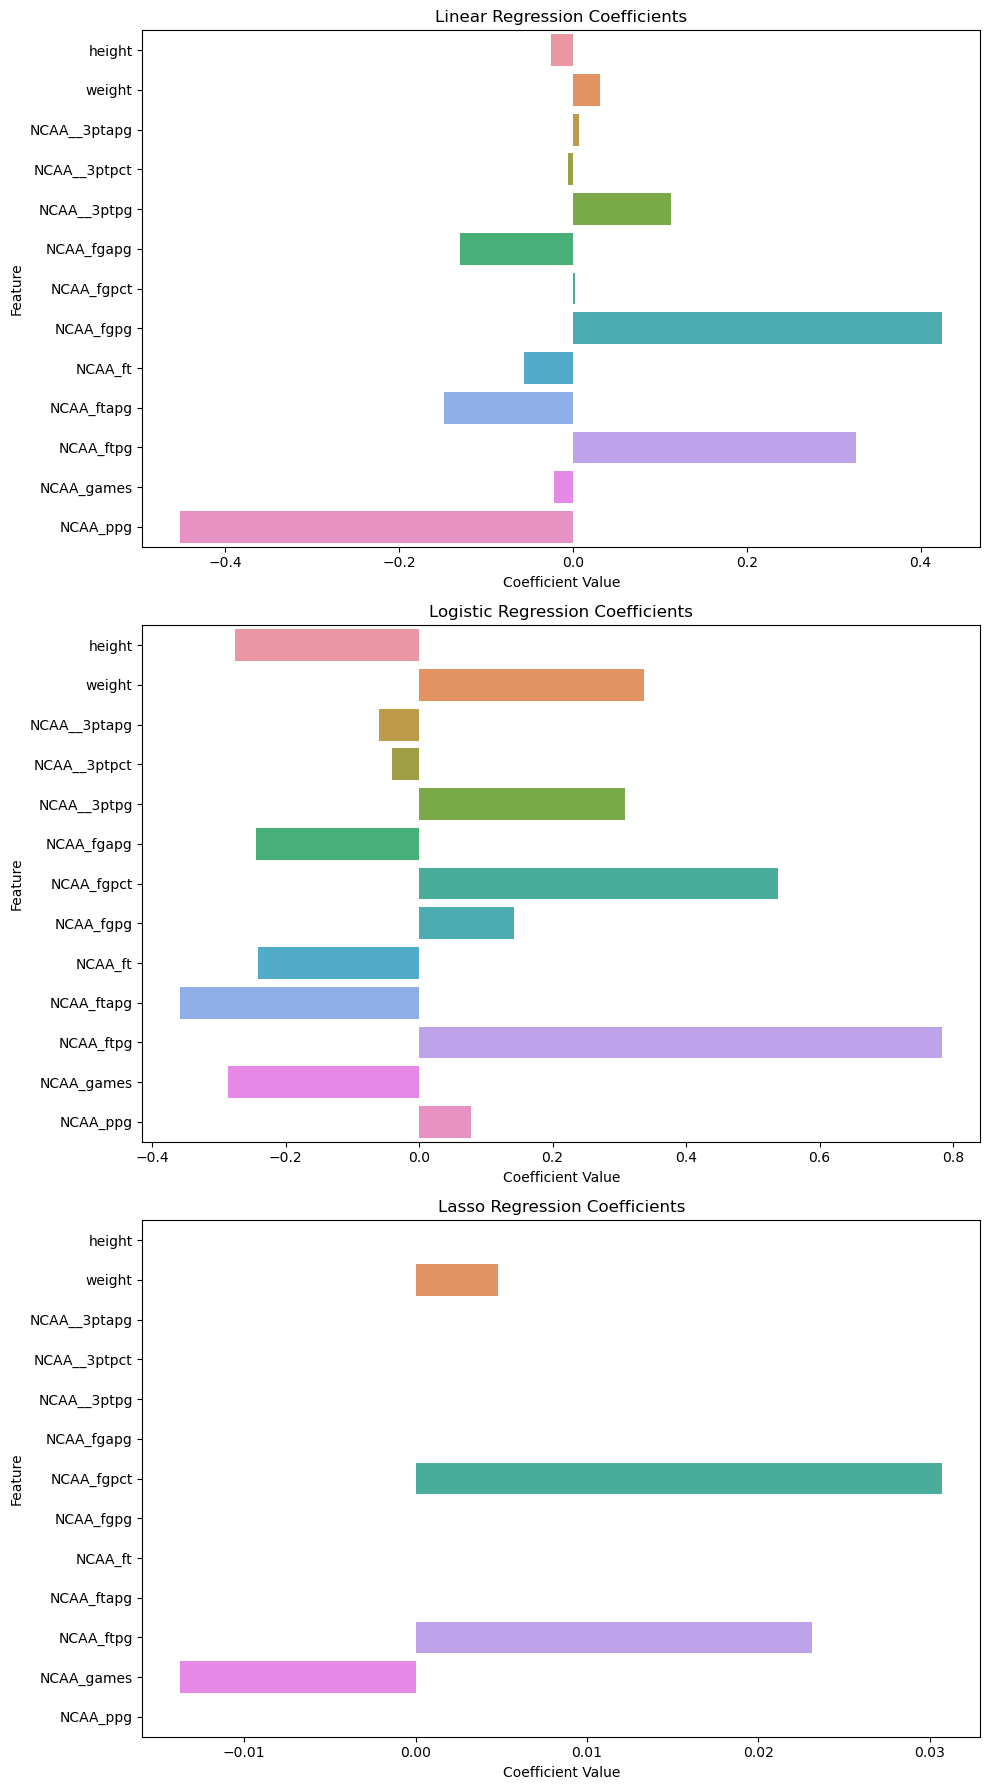

In [101]:
# Select features and target variable
features = ['height','weight', 
'NCAA__3ptapg', 'NCAA__3ptpct', 'NCAA__3ptpg', 'NCAA_fgapg',
'NCAA_fgpct', 'NCAA_fgpg', 'NCAA_ft', 'NCAA_ftapg', 'NCAA_ftpg', 'NCAA_games', 'NCAA_ppg']
X = data[features]
y = data['NBA_Success']

# Split the data into training and test sets (60% training, 40% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
linear_importance = pd.Series(linear_model.coef_, index=features)
print("Linear Regression Coefficients:")
print(linear_importance)

# Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train_scaled, y_train)
logistic_importance = pd.Series(logistic_model.coef_[0], index=features)
print("\nLogistic Regression Coefficients:")
print(logistic_importance)

# Lasso Regression with Cross-Validation
lasso_model = LassoCV(cv=5)
lasso_model.fit(X_train_scaled, y_train)
lasso_importance = pd.Series(lasso_model.coef_, index=features)
print("\nLasso Regression Coefficients:")
print(lasso_importance)

# Print R^2 score for Linear Regression on test set
#print("\nLinear Regression R^2 score on test set:", linear_model.score(X_test_scaled, y_test))

# Print accuracy score for Logistic Regression on test set
#print("Logistic Regression accuracy on test set:", logistic_model.score(X_test_scaled, y_test))

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Linear Regression Coefficients
sns.barplot(x=linear_importance.values, y=linear_importance.index, ax=axes[0])
axes[0].set_title('Linear Regression Coefficients')
axes[0].set_xlabel('Coefficient Value')
axes[0].set_ylabel('Feature')

# Logistic Regression Coefficients
sns.barplot(x=logistic_importance.values, y=logistic_importance.index, ax=axes[1])
axes[1].set_title('Logistic Regression Coefficients')
axes[1].set_xlabel('Coefficient Value')
axes[1].set_ylabel('Feature')

# Lasso Regression Coefficients
sns.barplot(x=lasso_importance.values, y=lasso_importance.index, ax=axes[2])
axes[2].set_title('Lasso Regression Coefficients')
axes[2].set_xlabel('Coefficient Value')
axes[2].set_ylabel('Feature')

plt.tight_layout()
plt.show()